<a href="https://colab.research.google.com/github/chetanvartak/llm_journey/blob/main/lm_playground_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Project 1: Build an LLM Playground

Welcome! In this project, you’ll learn foundations of large language models (LLMs). We’ll keep the code minimal and the explanations high‑level so that anyone who can run a Python cell can follow along.  

We'll be using Google Colab for this project. Colab is a free, browser-based platform that lets you run Python code and machine learning models without installing anything on your local computer. Click the button below to open this notebook directly in Google Colab and get started!


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bytebyteai/ai-eng-projects/blob/main/project_1/lm_playground.ipynb)

---
## Learning Objectives  
* **Tokenization** and how raw text is tokenized into a sequene of discrete tokens
* Inspect **GPT2** and **Transformer architecture**
* Loading pre-trained LLMs using **Hugging Face**
* **Decoding strategies** to generate text from LLMs
* Completion versus **intrusction fine-tuned** LLMs


Let's get started!

In [1]:
import torch, transformers, tiktoken
print("torch", torch.__version__, "| transformers", transformers.__version__)

torch 2.8.0+cu126 | transformers 4.56.2


# 1 - Tokenization

A neural network can’t digest raw text. They need **numbers**. Tokenization is the process of converting text into IDs. In this section, you'll learn how tokenization is implemented in practice.

Tokenization methods generally fall into three categories:
1. Word-level
2. Character-level
3. Subword-level

### 1.1 - Word‑level tokenization

Split text on whitespace and store each **word** as a token.

In [2]:
# 1. Tiny corpus
corpus = [
    "The quick brown fox jumps over the lazy dog",
    "Tokenization converts text to numbers",
    "Large language models predict the next token"
]

# 2. Build the vocabulary
PAD, UNK = "[PAD]", "[UNK]"
vocab = []
word2id = {}
id2word = {}

word_key = 0
for item in corpus:
  for word in item.split():
    if word not in word2id:
      word2id[word] = word_key
      id2word[word_key] = word
    word_key += 1

vocab = list(word2id.keys())

print(f"Vocabulary size: {len(vocab)} words")
print("First 15 vocab entries:", vocab[:15])

# 3. Encode / decode
def encode(text):
  ids = []
  for word in text.split():
    ids.append(word2id.get(word, UNK))
  return ids

def decode(ids):
  words = []
  for id in ids:
    words.append(id2word.get(id, UNK))
  return words

# 4. Demo
sample = "The brown unicorn jumps"
ids = encode(sample)
recovered = decode(ids)

print("\nInput text :", sample)
print("Token IDs  :", ids)
print("Decoded    :", recovered)

Vocabulary size: 20 words
First 15 vocab entries: ['The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', 'Tokenization', 'converts', 'text', 'to', 'numbers', 'Large']

Input text : The brown unicorn jumps
Token IDs  : [0, 2, '[UNK]', 4]
Decoded    : ['The', 'brown', '[UNK]', 'jumps']


Word-level tokenization has two major limitations:
1. Large vocabulary size
2. Out-of-vocabulary (OOV) issue

### 1.2 - Character‑level tokenization

Every single character (including spaces and emojis) gets its own ID. This guarantees zero out‑of‑vocabulary issues but very long sequences.

In [3]:
# 1. Build a fixed vocabulary # a–z + A–Z + padding + unkwown
import string

vocab = []
char2id = {}
id2char = {}

char_key = 0
for item in corpus:
  for char in item:
    if char not in char2id:
      char2id[char] = char_key
      id2char[char_key] = char
    char_key += 1

vocab = list(char2id.keys())

print(f"Vocabulary size: {len(vocab)} (52 letters + 2 specials)")

# 2. Encode / decode
def encode(text):
  ids = []
  for char in text:
    ids.append(char2id.get(char, UNK))
  return ids

def decode(ids):
  chars = []
  for id in ids:
    chars.append(id2char.get(id, UNK))
  return chars

# 3. Demo
sample = "Hello"
ids = encode(sample)
recovered = decode(ids)

print("\nInput text :", sample)
print("Token IDs  :", ids)
print("Decoded    :", recovered)


Vocabulary size: 29 (52 letters + 2 specials)

Input text : Hello
Token IDs  : ['[UNK]', 2, 35, 35, 12]
Decoded    : ['[UNK]', 'e', 'l', 'l', 'o']


### 1.3 - Subword‑level tokenization

Sub-word methods such as `Byte-Pair Encoding (BPE)`, `WordPiece`, and `SentencePiece` **learn** the most common character and gorup them into new tokens. For example, the word `unbelievable` might turn into three tokens: `["un", "believ", "able"]`. This approach strikes a balance between word-level and character-level methods and fix their limitations.

For example, `BPE` algorithm forms the vocabulary using the following steps:
1. **Start with bytes** → every character is its own token.  
2. **Count all adjacent pairs** in a huge corpus.  
3. **Merge the most frequent pair** into a new token.  
   *Repeat steps 2-3* until you hit the target vocab size (e.g., 50 k).

Let's see `BPE` in practice.

In [4]:
# 1. Load a pretrained BPE tokenizer (GPT-2 uses BPE).
# Refer to  https://huggingface.co/docs/transformers/en/fast_tokenizers

from transformers import AutoTokenizer
bpe_tok = AutoTokenizer.from_pretrained("gpt2")
print(bpe_tok)
print(bpe_tok.vocab_size)
vocab_dict = bpe_tok.get_vocab()

# Sort the vocabulary items by token ID and get the first 100
first_100_tokens = sorted(vocab_dict.items(), key=lambda item: item[1])[5000:5010]

# Print the tokens and their IDs
for token, token_id in first_100_tokens:
    print(f"{token_id:5} -> '{token}'")

# 2. Encode / decode
def encode(text):
    tokens = bpe_tok.tokenize(text)
    print(tokens)
    print(bpe_tok.convert_tokens_to_ids(tokens))
    return bpe_tok.convert_tokens_to_ids(tokens)

def decode(ids):
  return bpe_tok.decode(ids)

# 3. Demo
sample = "Unbelievable tokenization powers! 🚀"
ids = encode(sample)
recovered = decode(ids)

print("\nInput text :", sample)
print("Token IDs  :", ids)
print("Tokens     :", bpe_tok.convert_ids_to_tokens(ids))
print("Decoded    :", recovered)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)
50257
 5000 -> 'Ġentirely'
 5001 -> 'Ġpurchase'
 5002 -> 'Ġelement'
 5003 -> 'Ġcash'
 5004 -> 'Ġdetermine'
 5005 -> 'De'
 5006 -> 'Ġcars'
 5007 -> 'ĠWall'
 5008 -> 'âĸ'
 5009 -> 'Ġviews'
['Un', 'bel', 'iev', 'able', 'Ġtoken', 'ization', 'Ġpowers', '!', 'ĠðŁ', 'ļ', 'Ģ']
[3118, 6667, 11203, 540, 11241, 1634, 5635, 0, 12520, 248, 222]

Input text : Unbelievable tokenization powers! 🚀
Token IDs  : [3118, 6667, 11203, 540, 11241, 1634, 5635, 0, 12520, 248, 222]
Tokens     : ['Un', 'bel', 'iev', 'able', 'Ġtoken', 'ization', 'Ġpowers', '!', 'ĠðŁ', 'ļ', 'Ģ']
Decoded    : Unbe

### 1.4 - TikToken

`tiktoken` is a production-ready library which offers high‑speed tokenization used by OpenAI models.  
Let's compare the older **gpt2** encoding with the newer **cl100k_base** used in GPT‑4.

In [5]:
# Use gpt2 and cl100k_base to encode and decode the following text
# Refer to https://github.com/openai/tiktoken
import tiktoken
sentence = "The 🌟 star-player scored 40 points!"
tokenizer = tiktoken.encoding_for_model("gpt2")
print(tokenizer)
print(tokenizer.n_vocab)

tokens = tokenizer.encode(sentence)
print(tokens)

print(tokenizer.decode(tokens))

tokenizer = tiktoken.encoding_for_model("gpt-3.5")
tokens = tokenizer.encode(sentence)
print(tokenizer)
print(tokenizer.n_vocab)
print(tokens)

print(tokenizer.decode(tokens))

tokenizer = tiktoken.encoding_for_model("gpt-4o")
tokens = tokenizer.encode(sentence)
print(tokenizer)
print(tokenizer.n_vocab)
print(tokens)

print(tokenizer.decode(tokens))

tokenizer = tiktoken.get_encoding("cl100k_base")
tokens = tokenizer.encode(sentence)
print(tokenizer)
print(tokenizer.n_vocab)
print(tokens)

print(tokenizer.decode(tokens))

<Encoding 'gpt2'>
50257
[464, 12520, 234, 253, 3491, 12, 7829, 7781, 2319, 2173, 0]
The 🌟 star-player scored 40 points!
<Encoding 'cl100k_base'>
100277
[791, 11410, 234, 253, 6917, 43467, 16957, 220, 1272, 3585, 0]
The 🌟 star-player scored 40 points!
<Encoding 'o200k_base'>
200019
[976, 130321, 253, 8253, 92135, 27207, 220, 1723, 5571, 0]
The 🌟 star-player scored 40 points!
<Encoding 'cl100k_base'>
100277
[791, 11410, 234, 253, 6917, 43467, 16957, 220, 1272, 3585, 0]
The 🌟 star-player scored 40 points!


BPE_Implementation Sample

In [6]:
import collections

def get_stats(vocab):
    """
    Computes the frequency of adjacent pairs of symbols in the vocabulary.
    """
    pairs = collections.defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i], symbols[i+1]] += freq
    return pairs

def merge_vocab(pair, v_in):
    """
    Merges the most frequent pair in the vocabulary.
    """
    v_out = {}
    bigram = ' '.join(pair)
    replacement = ''.join(pair)
    for word in v_in:
        w_out = word.replace(bigram, replacement)
        v_out[w_out] = v_in[word]
    return v_out

# 1. Initialize vocabulary
# The keys are the words tokenized into characters, separated by spaces.
vocab = {
    'h u g': 10,
    'p u g': 5,
    'p u n': 12,
    'b u n': 4,
    'h u g s': 5
}

# 2. Set the number of merge operations
num_merges = 5

print("--- Initial Vocabulary ---")
print(vocab)
print("-" * 25)


# 3. Iteratively merge the most frequent pair
for i in range(num_merges):
    print(f"\n>>> Iteration {i+1}")

    # Get frequency of adjacent pairs
    pairs = get_stats(vocab)

    if not pairs:
        break

    # Find the most frequent pair
    best_pair = max(pairs, key=pairs.get)
    print(f"Most frequent pair: {best_pair} (Frequency: {pairs[best_pair]})")

    # Merge the pair in the vocabulary
    vocab = merge_vocab(best_pair, vocab)

    print("Updated Vocabulary:")
    print(vocab)

print("\n--- Final Vocabulary ---")
print(vocab)

# The final vocabulary contains the new merged tokens like 'ug', 'un', etc.
# The learned merge rules are the `best_pair` from each iteration.

--- Initial Vocabulary ---
{'h u g': 10, 'p u g': 5, 'p u n': 12, 'b u n': 4, 'h u g s': 5}
-------------------------

>>> Iteration 1
Most frequent pair: ('u', 'g') (Frequency: 20)
Updated Vocabulary:
{'h ug': 10, 'p ug': 5, 'p u n': 12, 'b u n': 4, 'h ug s': 5}

>>> Iteration 2
Most frequent pair: ('u', 'n') (Frequency: 16)
Updated Vocabulary:
{'h ug': 10, 'p ug': 5, 'p un': 12, 'b un': 4, 'h ug s': 5}

>>> Iteration 3
Most frequent pair: ('h', 'ug') (Frequency: 15)
Updated Vocabulary:
{'hug': 10, 'p ug': 5, 'p un': 12, 'b un': 4, 'hug s': 5}

>>> Iteration 4
Most frequent pair: ('p', 'un') (Frequency: 12)
Updated Vocabulary:
{'hug': 10, 'p ug': 5, 'pun': 12, 'b un': 4, 'hug s': 5}

>>> Iteration 5
Most frequent pair: ('p', 'ug') (Frequency: 5)
Updated Vocabulary:
{'hug': 10, 'pug': 5, 'pun': 12, 'b un': 4, 'hug s': 5}

--- Final Vocabulary ---
{'hug': 10, 'pug': 5, 'pun': 12, 'b un': 4, 'hug s': 5}


Experiment: try new sentences, emojis, code snippets, or other languages. If you are interested, try implementing the BPE algorithm yourself.

### 1.5 - Key Takeaways

* **Word‑level**: simple but brittle (OOV problems).  
* **Character‑level**: robust but produces long sequences.  
* **BPE / Byte‑Level BPE**: middle ground used by most LLMs.  
* **tiktoken**: shows how production models tokenize with pre‑trained sub‑word vocabularies.

# 2. What is a Language Model?

At its core, a **language model (LM)** is just a *very large* mathematical function built from many neural-network layers.  
Given a sequence of tokens `[t₁, t₂, …, tₙ]`, it learns to output a probability for the next token `tₙ₊₁`.


Each layer applies a simple operation (matrix multiplication, attention, etc.). Stacking hundreds of these layers lets the model capture patterns and statistical relations from text. The final output is a vector of scores that says, “how likely is each possible token to come next?”

> Think of the whole network as **one gigantic equation** whose parameters were tuned during training to minimize prediction error.


Simple Linear Example

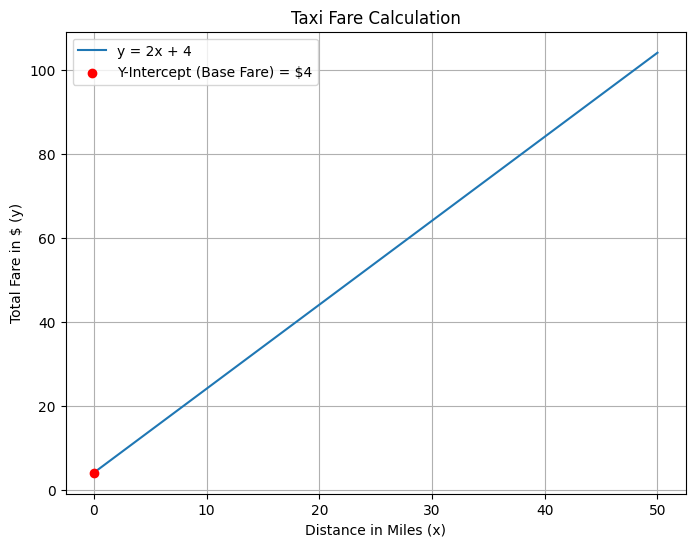

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Taxi fare parameters from our example
W = 2  # $2 per mile
b = 4  # $4 base fare

# Generate a range of distances (x values) from 0 to 50 miles
x_values = np.linspace(0, 50, 100) # 100 points between 0 and 50

# Calculate the corresponding y values (total fare) for each distance
y_values = (W * x_values) + b

# Plotting the line
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label=f'y = {W}x + {b}')

# Highlight the y-intercept (the base fare when distance x=0)
plt.scatter(0, b, color='red', zorder=5, label=f'Y-Intercept (Base Fare) = ${b}')

# Adding labels and title for clarity
plt.title('Taxi Fare Calculation')
plt.xlabel('Distance in Miles (x)')
plt.ylabel('Total Fare in $ (y)')
plt.grid(True)
plt.legend()
plt.show()

Sample Linear Transform


In [8]:
import numpy as np

# Let's imagine our input is a vector with 3 features
# (e.g., [house_size, num_bedrooms, age_of_house])
x = np.array([1500, 3, 20])

# --- Define the Linear Layer ---

# The Weight Matrix 'W' must have a shape of (num_outputs, num_inputs)
# In our case, that's (2, 3)
# It holds all the connection strengths.
W = np.array([
    [0.1,  0.4, -0.2],  # Weights for the 1st output
    [0.5, -0.1,  0.3]   # Weights for the 2nd output
])

# The Bias Vector 'b' must have a shape of (num_outputs,)
# One bias for each output.
b = np.array([2, 5])

# --- Apply the Linear Transform ---
# The core operation: y = Wx + b
# np.dot() performs the matrix multiplication.
y = np.dot(W, x) + b

print(f"Input vector (x) shape: {x.shape}")
print(f"Weight matrix (W) shape: {W.shape}")
print(f"Bias vector (b) shape: {b.shape}")
print("-" * 30)
print(f"Input vector x:\n{x}\n")
print(f"Output vector y:\n{y}")
print(f"\nOutput vector (y) shape: {y.shape}")


Input vector (x) shape: (3,)
Weight matrix (W) shape: (2, 3)
Bias vector (b) shape: (2,)
------------------------------
Input vector x:
[1500    3   20]

Output vector y:
[149.2 760.7]

Output vector (y) shape: (2,)


With PyTorch


In [9]:
import torch
import torch.nn as nn

# --- Define the Layer ---

# We need a layer that accepts 3 input features and produces 2 output features.
in_features = 3
out_features = 2
linear_layer = nn.Linear(in_features, out_features)

# --- Prepare the Input Data ---

# Our input data (e.g., [house_size, num_bedrooms, age_of_house])
# It must be a PyTorch Tensor, not a NumPy array.
x = torch.tensor([1500.0, 3.0, 20.0], dtype=torch.float32)

# IMPORTANT: PyTorch layers expect a BATCH of inputs, not just a single one.
# So, we need to add a "batch dimension" to our input tensor.
# The shape changes from (3,) to (1, 3), representing a batch of 1 item.
x = x.unsqueeze(0)

# --- Apply the Linear Transform ---

# Simply "call" the layer with your input data.
# PyTorch handles the y = Wx + b calculation behind the scenes.
output = linear_layer(x)

print(f"Input tensor shape: {x.shape}")
print(f"Output tensor shape: {output.shape}\n")
print(f"Input tensor x:\n{x}\n")
print(f"Output tensor y:\n{output}")

Input tensor shape: torch.Size([1, 3])
Output tensor shape: torch.Size([1, 2])

Input tensor x:
tensor([[1500.,    3.,   20.]])

Output tensor y:
tensor([[-380.8770, -200.9268]], grad_fn=<AddmmBackward0>)



### 2.1 - A Single `Linear` Layer

Before we explore Transformer, let’s start tiny:

* A **Linear layer** performs `y = Wx + b`  
  * `x` – input vector  
  * `W` – weight matrix (learned)  
  * `b` – bias vector (learned)

Although this looks basic, chaining thousands of such linear transforms (with nonlinearities in between) gives neural nets their expressive power.


In [ ]:
import torch.nn as nn
class Linear(nn.Module):
    def __init__(self, in_features, out_features):
        super(Linear, self).__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.1)
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
      return torch.matmul(x, self.weight.T) + self.bias


In [ ]:
import torch.nn as nn, torch

lin = nn.Linear(3, 2)
x = torch.tensor([1.0, -1.0, 0.5])
print("Input :", x)
print("Weights:", lin.weight)
print("Bias   :", lin.bias)
print("Output :", lin(x))


Input : tensor([ 1.0000, -1.0000,  0.5000])
Weights: Parameter containing:
tensor([[-0.3605,  0.0040, -0.4891],
        [ 0.5371,  0.3731,  0.4417]], requires_grad=True)
Bias   : Parameter containing:
tensor([ 0.4721, -0.2014], requires_grad=True)
Output : tensor([-0.1370,  0.1834], grad_fn=<ViewBackward0>)


### 2.2 - A `Transformer` Layer

Most LLMs are a **stack of identical Transformer blocks**. Each block fuses two main components:

| Step | What it does | Where it lives in code |
|------|--------------|------------------------|
| **Multi-Head Self-Attention** | Every token looks at every other token and decides *what matters*. | `block.attn` |
| **Feed-Forward Network (MLP)** | Re-mixes information token-by-token. | `block.mlp` |

Below, we load the smallest public GPT-2 (124 M parameters), grab its *first* block, and inspect the pieces.


In [ ]:
import torch
from transformers import GPT2LMHeadModel

# Load the 124 M-parameter GPT-2 and inspect its layers (12 layers)
"""
YOUR CODE HERE
"""

In [ ]:
# Run a tiny forward pass through the first block
seq_len = 8
dummy_tokens = torch.randint(0, gpt2.config.vocab_size, (1, seq_len))
with torch.no_grad():
    # Embed tokens + positions the same way GPT-2 does
    # Forward through one layer
    """
    YOUR CODE HERE
    """

print("\nOutput shape :", out.shape) # (batch, seq_len, hidden_size)

### 2.3 - Inside GPT-2

GPT-2 is just many of those modules arranged in a repeating *block*. Let's print the modules inside the Transformer.

In [ ]:
# Print the name and modules inside gpt2
"""
YOUR CODE HERE
"""

As you can see, the Transformer holds various modules, arranged from a list of blocks (`h`). The following table summarizes these modules:

| Step | What it does | Why it matters |
|------|--------------|----------------|
| **Token → Embedding** | Converts IDs to vectors | Gives the model a numeric “handle” on words |
| **Positional Encoding** | Adds “where am I?” info | Order matters in language |
| **Multi-Head Self-Attention** | Each token asks “which other tokens should I look at?” | Lets the model relate words across a sentence |
| **Feed-Forward Network** | Two stacked Linear layers with a non-linearity | Mixes information and adds depth |
| **LayerNorm & Residual** | Stabilize training and help gradients flow | Keeps very deep networks trainable |


### 2.4 LLM's output

Passing a token sequence through an **LLM** yields a tensor of **logits** with shape  
`(batch_size, seq_len, vocab_size)`.  
Applying `softmax` on the last dimension turns those logits into probabilities.

The cell below feeds an 8-token dummy sequence, prints the logits shape, and shows the five most likely next tokens for the final position.


In [ ]:
import torch, torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# Load gpt2 model and tokenizer
"""
YOUR CODE HERE
"""

# Tokenize input text
text = "Hello my name"
"""
YOUR CODE HERE
"""

# Get logits by passing the ids to the gpt2 model.
"""
YOUR CODE HERE
"""

print("Logits shape :", logits.shape)

# Predict next token
"""
YOUR CODE HERE
"""

print("\nTop-5 predictions for the next token:")
"""
YOUR CODE HERE
"""


### 2.5 - Key Takeaway

A language model is nothing mystical: it’s a *huge composition* of small, understandable layers trained to predict the next token in a sequence of tokens.

# 3 - Generation
Once an LLM is trained to predict the probabilities, we can generate text from the model. This process is called decoding or sampling.

At each step, the LLM outputs a **probability distribution** over the next token. It is the job of the decoding algorithm to pick the next token, and move on to the next token. There are different decoding algorithms and hyper-parameters to control the generaiton:
* **Greedy** → pick the single highest‑probability token each step (safe but repetitive).  
* **Top‑k / Nucleus (top‑p)** → sample from a subset of likely tokens (adds variety).
* **beam** -> applies beam search to pick tokens
* **Temperature** → a *creativity* knob. Higher values flatten the probability distribution.

### 3.1 - Greedy decoding

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
MODELS = {
    "gpt2": "gpt2",
}
tokenizers, models = {}, {}
# Load models and tokenizers
"""
YOUR CODE HERE
"""

def generate(model_key, prompt, strategy="greedy", max_new_tokens=100):
    tok, mdl = tokenizers[model_key], models[model_key]
    # Return the generations based on the provided strategy: greedy, top_k, top_p
    """
    YOUR CODE HERE
    """


In [ ]:
tests=["Once upon a time","What is 2+2?", "Suggest a party theme."]
for prompt in tests:
    print(f"\n== GPT-2 | Greedy ==")
    print(generate("gpt2", prompt, "greedy", 80))



Naively picking the single best token every time has the following issues in practice:

* **Loop**: “The cat is is is…”  
* **Miss long-term payoff**: the highest-probability word *now* might paint you into a boring corner later.

### 3.2 - Top-k or top-p sampling

In [ ]:

tests=["Once upon a time","What is 2+2?", "Suggest a party theme."]
for prompt in tests:
    print(f"\n== GPT-2 | Top-p ==")
    print(generate("gpt2", prompt, "top-p", 40))


### 3.3 - Try It Yourself

1. Scroll to the list called `tests`.
2. Swap in your own prompts or tweak the decoding strategy.  
3. Re‑run the cell and compare the vibes.

> **Tip:** Try the same prompt with `greedy` vs. `top_p` (0.9) and see how the tone changes. Notice especially how small temperature tweaks can soften or sharpen the prose.

* `strategy`: `"greedy"`, `"beam"`, `"top_k"`, `"top_p"`  
* `temperature`: `0.2 – 2.0`  
* `k` or `p` thresholds



# 4 - Completion vs. Instruction-tuned LLMs

We have seen that we can use GPT2 model to pass an input text and generate a new text. However, this model only continues the provided text. It is not engaging in a dialouge-like conversation and cannot be helpful by answering instructions. On the other hand, **instruction-tuned LLMs** like `Qwen-Chat` go through an extra training stage called **post-training** after the base “completion” model is finished. Because of post-training step, an instruction-tuned LLM will:

* **Read the entire prompt as a request,** not just as text to mimic.  
* **Stay in dialogue mode**. Answer questions, follow steps, ask clarifying queries.  
* **Refuse or safe-complete** when instructions are unsafe or disallowed.  
* **Adopt a consistent persona** (e.g., “Assistant”) rather than drifting into story continuation.


### 4.1 - Qwen1.5-8B vs. GPT2

In the code below we’ll feed the same prompt to:

* **GPT-2 (completion-only)** – it will simply keep writing in the same style.  
* **Qwen-Chat (instruction-tuned)** – it will obey the instruction and respond directly.

Comparing the two outputs makes the difference easy to see.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
MODELS = {
    "gpt2": "gpt2",
    "qwen": "Qwen/Qwen1.5-1.8B-Chat"
}
tokenizers, models = {}, {}
# Load models and tokenizers
"""
YOUR CODE HERE
"""



We downloaded two tiny checkpoints: `GPT‑2` (124 M parameters) and `Qwen‑1.5‑Chat` (1.8 B). If the cell took a while, that was mostly network time. Models are stored locally after the first run.

Let's now generate text and compare two models.


In [ ]:

tests=[("Once upon a time","greedy"),("What is 2+2?","top_k"),("Suggest a party theme.","top_p")]
for prompt,strategy in tests:
    for key in ["gpt2","qwen"]:
        print(f"\n== {key.upper()} | {strategy} ==")
        print(generate(key,prompt,strategy,80))


# 5. (Optional) A Small LLM Playground

### 5.1 ‑ Interactive Playground

Enter a prompt, pick a model and decoding strategy, adjust the temperature, and press **Generate** to watch the model respond.


In [ ]:
import ipywidgets as widgets
from IPython.display import display, Markdown

# Make sure models and tokenizers are loaded
try:
    tokenizers
    models
except NameError:
    raise RuntimeError("Please run the earlier setup cells that load the models before using the playground.")

def generate_playground(model_key, prompt, strategy="greedy", temperature=1.0, max_new_tokens=100):
    # Generation code
    """
    YOUR CODE HERE
    """

# Your code to build boxes, dropdowns, and other elements in the UI using widgets and creating the UI using widgets.vbox and display.
# Refer to https://ipywidgets.readthedocs.io/en/stable/
"""
YOUR CODE HERE
"""



## 🎉 Congratulations!

You’ve just learned, explored, and inspected a real **LLM**. In one project you:
* Learned how **tokenization** works in practice
* Used `tiktoken` library to load and experiment with most advanced tokenizers.
* Explored LLM architecture and inspected GPT2 blocks and layers
* Learned decoding strategies and used `top-p` to generate text from GPT2
* Loaded a powerful chat model, `Qwen1.5-8B` and generated text
* Built an LLM playground


👏 **Great job!** Take a moment to celebrate. You now have a working mental model of how LLMs work. The skills you used here power most LLMs you see everywhere.
